# 課程目標:
    
    了解反向傳播的原理與在神經網路推倒過程中的作用

# 範例重點:

    (1)自定義神經網路架構
    
    (2) 初始值設定
    
    (3) 使用範例



In [1]:
#定義並建立一神經網路
class mul_layer():
    def _ini_(self):
        self.x = None
        self.y = None
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x*y
        return out
    def backward(self, dout):
        #先接受上層傳送來的資料dout
        #自己函數為x*y
        #對x微分 = y -> dout * y
        #對y微分 = x -> dout * x
        dx = dout * self.y
        dy = dout * self.x
        return dx, dy

In [2]:
# 初始值設定
#數量
n_X = 2
#單價
price_Y = 100
#稅金
b_TAX = 1.1

# 指定Build _Network組合
mul_fruit_layer = mul_layer()
mul_tax_layer = mul_layer()


# 以購買水果為例:
    
    付費總價格是根據水果價格, 稅金變動而受影響
    
    水果價格是根據購買數量與單品價格而變動
    
    可以利用每一個cell (cell - 1: 水果價格; cell - 2: 付費總價格), 推導微分的結果

In [3]:
#forward 
#水果價格 price_Y * n_X
fruit_price = mul_fruit_layer.forward(price_Y, n_X)
#付費總價格 fruit_price * b_TAX
total_price = mul_tax_layer.forward(fruit_price, b_TAX)

#backward 
dtotal_price = 1 #this is linear function, which y=x, dy/dx=1

#水果價格 與 稅金 對付費總價格微分
d_fruit_price, d_b_TAX = mul_tax_layer.backward(dtotal_price)
#單價 與 數量 對水果價格微分
d_price_Y, d_n_X =  mul_fruit_layer.backward(d_fruit_price)

In [4]:
#result
print("fruit price: %i"%fruit_price)
print("針對所有水果價格微分, 得到 TAX: %2f" %d_fruit_price)


fruit price: 200
針對所有水果價格微分, 得到 TAX: 1.100000


# BP 演算法訓練的神經網路


目標: 嘗試著用輸入去預測輸出, 了解權重的更新
 
考慮以上情形：
給定三row輸入，試著去預測對應的一row輸出。

我們可以通過簡單測量輸入與輸出值的資料來解決這一問題。

最左邊的一 row 輸入值和輸出值是完美匹配/完全相關的。

反向傳播演算法便是通過這種方式來衡量資料間統計關係進而得到模型的。


# 參數定義

X	輸入資料集，形式為矩陣，每 1 column 代表 1 個訓練樣本。

y	輸出資料集，形式為矩陣，每 1 column 代表 1 個訓練樣本。

l0	網路第 1 層，即網路輸入層。

l1	網路第 2 層，常稱作隱藏層。

syn0	第一層權值，突觸 0 ，連接 l0 層與 l1 層。

*	逐元素相乘，故兩等長向量相乘等同於其對等元素分別相乘，結果為同等長度的向量。

–	元素相減，故兩等長向量相減等同於其對等元素分別相減，結果為同等長度的向量。

x.dot(y)	若 x 和 y 為向量，則進行點積操作；若均為矩陣，則進行矩陣相乘操作；若其中之一為矩陣，則進行向量與矩陣相乘操作。


In [5]:
import numpy as np
 
# Sigmoid 函數可以將任何值都映射到一個位於 0 到  1 範圍內的值。通過它，我們可以將實數轉化為概率值
'''
定義數學函數:
y=f(x) = 1/(1+np.exp(-x));
dy/dx = df = y*(1-y) 

為了計算方便, 這邊把 y=f(x) 與 dy/dx 放在同一function 裡面;
利用 deriv (derivative)做變數, 來分別指定方程式

'''    
#Sigmoid Activation Function (False) 非微分版本
#Sigmoid Derivative (True) 微分版本
def nonlin(x,deriv=False):
    if(deriv==True):
        return x*(1-x)
    return 1/(1+np.exp(-x))
'''
通過 “nonlin” 函數體還能得到 sigmod 函數的導數（當形參 deriv 為 True 時）。
Sigmoid 函數優異特性之一，在於只用它的輸出值便可以得到其導數值。
若 Sigmoid 的輸出值用變數 out 表示，則其導數值可簡單通過式子 out *(1-out) 
'''

'''
input dataset
輸入資料集初始化為 numpy 中的矩陣。每一 column 為一個“訓練實例”，
每一 row 的對應著一個輸入節點。這樣，我們的神經網路便有 3 個輸入節點，
4 個訓練實例。
'''
# X (4,3)
X = np.array([  [0,0,1],
                [0,1,1],
                [1,0,1],
                [1,1,1] ])  
        
# define output dataset 
# y (4,1)
y = np.array([[0,0,1,1]]).T

'''
輸出資料集進行初始化
.T” 為轉置函數。經轉置後，該  y  矩陣便包含 4 column 1 row。
同我們的輸入一致，每一 column 是一個訓練實例，而每一row（僅有一row）對應一個輸出節點。
因此，我們的網路含有 3 個輸入， 1 個輸出
'''

# seed random numbers to make calculation
# deterministic (just a good practice)
np.random.seed(1)
#亂數設定產生種子得到的權重初始化集仍是隨機分佈的，
#但每次開始訓練時，得到的權重初始集分佈都是完全一致的。
 
# initialize weights randomly with mean 0
# 隨機初始化 weights 參數 4筆資料 3個特徵 -> 3個參數
syn0 = 2*np.random.random((3,1)) - 1
iter = 0

syn0_history = [syn0]
#該神經網路權重矩陣的初始化操作。
#用 “syn0” 來代指 (即“輸入層-第一層隱層”間權重矩陣）


# 神經網路訓練
for 迴圈反覆運算式地多次執行訓練代碼，使得我們的網路能更好地擬合訓練集

In [6]:
for iter in range(10000):
    # forward propagation
    # input
    l0 = X
    # 第一層
    l1 = nonlin(np.dot(l0,syn0))
    
    '''
    首先讓網路基於給定輸入“試著”去預測輸出。
    以至於作出一些調整，使得在每次反覆運算過程中網路能夠表現地更好一點。
    (4 x 3) dot (3 x 1) = (4 x 1)
    此 column 代碼包含兩個步驟。首先，將 l0 與 syn0 進行矩陣相乘。
    然後，將計算結果傳遞給 sigmoid 函數。具體考慮到各個矩陣的維度：
    (4 x 3) dot (3 x 1) = (4 x 1)
    '''
 
    # how much did we miss?
    # (4,1)
    l1_error = y - l1
 
    # multiply how much we missed by the 
    # slope of the sigmoid at the values in l1
    # Backpropagation
    # 計算第一層的梯度
    # (4,1)
    l1_delta = l1_error * nonlin(l1,True)
    
    '''
    對於每一輸入，可知 l1 都有對應的一個“猜測”結果。那麼通過將真實的結果（y）與猜測結果（l1）作減，
    就可以對比得到網路預測的效果怎麼樣。
    l1_error 是一個有正數和負數組成的向量，它可以反映出網路的誤差有多大
    '''
    # update weights
    # (3,4) * (4,1) = (3,1)
    syn0 += np.dot(l0.T,l1_delta)
    
print("Output After Training:")
print("\n")
print(l1)

Output After Training:


[[0.00966449]
 [0.00786506]
 [0.99358898]
 [0.99211957]]


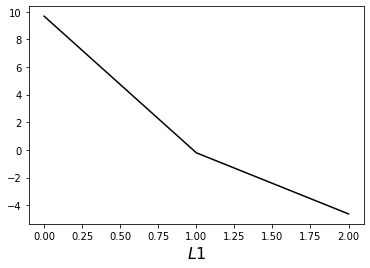

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline 
#適用於 Jupyter Notebook, 宣告直接在cell 內印出執行結果

plt.plot(syn0_history[0], ms=3, lw=1.5, color='black')
plt.xlabel(r'$L1$', fontsize=16)
plt.show()

# 作業目標:

    通過建立多層的神經網路, 了解權值矩陣更新

# 作業重點: 

3  層神經網路

通過增加更多的中間層，以對更多關係的組合進行建模

syn1 權值矩陣將隱層的組合輸出映射到最終結果，

而在更新 syn1 的同時，還需要更新 syn0 權值矩陣，

以從輸入資料中更好地產生這些組合

In [8]:
import numpy as np
 
# Sigmoid 函數可以將任何值都映射到一個位於 0 到  1 範圍內的值。通過它，我們可以將實數轉化為概率值
def nonlin(x,deriv=False):
    if(deriv==True):
        return x*(1-x)
    return 1/(1+np.exp(-x))

X = np.array([  [0,0,1],
                [0,1,1],
                [1,0,1],
                [1,1,1] ])  
        
# define y for output dataset            
y = np.array([[0,0,1,1]]).T

In [9]:

# seed random numbers to make calculation
# deterministic (just a good practice)
np.random.seed(1)
#亂數設定產生種子得到的權重初始化集仍是隨機分佈的，
#但每次開始訓練時，得到的權重初始集分佈都是完全一致的。
 
# initialize weights randomly with mean 0
syn0 = 2*np.random.random((3,4)) - 1
# define syn1
syn1 = 2*np.random.random((4,1)) - 1
iter = 0
#該神經網路權重矩陣的初始化操作。
#用 “syn0” 來代指 (即“輸入層-第一層隱層”間權重矩陣）
#用 “syn1” 來代指 (即“輸入層-第二層隱層”間權重矩陣）
syn0_history = [syn0]
syn1_history = [syn1]

神經網路訓練
for 迴圈反覆運算式地多次執行訓練代碼，使得我們的網路能更好地擬合訓練集

In [10]:
for iter in range(10000):
    # forward propagation
    l0 = X
    l1 = nonlin(np.dot(l0, syn0))
    l2 = nonlin(np.dot(l1, syn1))
    '''
    新增
    l2_error 該值說明了神經網路預測時“丟失”的數目。
    l2_delta 該值為經確信度加權後的神經網路的誤差，除了確信誤差很小時，它近似等於預測誤差。
    '''
    l2_error = y - l2
    l2_delta = l2_error * nonlin(l2, True)
    syn1 += np.dot(l1.T, l2_delta)
    
    # how much did we miss?
    l1_error = np.dot(l2_delta, syn1.T)
 
    # multiply how much we missed by the 
    # slope of the sigmoid at the values in l1
    l1_delta = l1_error * nonlin(l1,True)
    
    # update weights
    syn0 += np.dot(l0.T,l1_delta)
     # syn1 update weights
    
print("Output After Training:")
print(l1)
print("\n\n")
print(l2)

Output After Training:
[[0.66780156 0.19558995 0.86087132 0.60930032]
 [0.57880081 0.1328346  0.86485729 0.55264474]
 [0.1480122  0.94504078 0.0629486  0.64385209]
 [0.10615012 0.91549084 0.06496519 0.58882574]]



[[0.00510117]
 [0.00422212]
 [0.99491503]
 [0.99435233]]


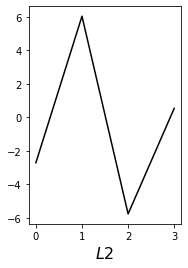

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline 
#適用於 Jupyter Notebook, 宣告直接在cell 內印出執行結果

plt.subplot(1,2,2)
plt.plot(syn1_history[0], ms=3, lw=1.5, color='black')
plt.xlabel(r'$L2$', fontsize=16)
plt.show()